In [1]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
params = {
    'dropout': 0.8
}

In [4]:
def stochastic_net(x, layers, output_dim):
    for layer in layers:
        x = tf.layers.dense(x, layer, activation=tf.nn.tanh)
        x = tf.nn.dropout(x, params['dropout'])
    mu = tf.layers.dense(x, output_dim)
    var = tf.exp(tf.layers.dense(x, output_dim))
    return mu, var

In [5]:
# Size of input image
input_size = 784
# Size of latent vectors
z_dim = 100
# Sizes of hidden layers in encoder and decoder
layers_encoder = [128]
layers_decoder = [128]

In [6]:
tf.reset_default_graph()
# Create our input placeholders
images = tf.placeholder(tf.float32, (None, input_size), name='image')

# Build the model
e_mu, e_var = stochastic_net(images, layers_encoder, z_dim)
eps = tf.random_normal([tf.shape(images)[0], z_dim], mean=0.0, stddev=1.0)
z = e_mu + tf.sqrt(e_var) * eps
d_mu, _ = stochastic_net(z, layers_decoder, input_size)
d_mu = tf.nn.sigmoid(d_mu)

In [7]:
# Calculate losses
loss_encode = - 0.5 * tf.reduce_sum(1 + tf.log(e_var) - e_mu ** 2 - e_var, axis=1)
loss_decode = - tf.reduce_sum(tf.contrib.distributions.Normal(d_mu, 0.3).log_prob(images), axis=1)
loss = tf.reduce_mean(loss_encode + loss_decode, axis=0)

In [8]:
# Optimizers
learning_rate = 0.0002 # 0.002

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [9]:
batch_size = 100
epochs = 50
samples = []
losses = []
# Only save generator variables
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images
            batch_images = batch[0].reshape((batch_size, input_size))
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            
            # Run optimizer
            sess.run(train_op, feed_dict={images: batch_images})
        
        # At the end of each epoch, get the loss and print it out
        train_loss = sess.run(loss, {images: batch_images})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Loss: {:.4f}".format(train_loss))
        # Save losses to view after training
        losses.append(train_loss)
        
        # Sample an image as we're training for viewing afterwards
        sample_z = np.random.randn(16, z_dim)
        gen_samples = sess.run(
                       d_mu,
                       feed_dict={z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')
        if np.isnan(train_loss):
            print 'loss is NaN!'
            break

('Epoch 1/50...', 'Loss: 84.7365')
('Epoch 2/50...', 'Loss: 19.3417')
('Epoch 3/50...', 'Loss: 8.9540')
('Epoch 4/50...', 'Loss: -0.5970')
('Epoch 5/50...', 'Loss: -17.8746')
('Epoch 6/50...', 'Loss: -29.7983')
('Epoch 7/50...', 'Loss: -31.4287')
('Epoch 8/50...', 'Loss: -35.5343')
('Epoch 9/50...', 'Loss: -50.8257')
('Epoch 10/50...', 'Loss: -42.7437')
('Epoch 11/50...', 'Loss: -51.8860')
('Epoch 12/50...', 'Loss: -55.8375')
('Epoch 13/50...', 'Loss: -61.0460')
('Epoch 14/50...', 'Loss: -67.5756')
('Epoch 15/50...', 'Loss: -72.3925')
('Epoch 16/50...', 'Loss: -65.9594')
('Epoch 17/50...', 'Loss: -65.9233')
('Epoch 18/50...', 'Loss: -75.5668')
('Epoch 19/50...', 'Loss: -70.6633')
('Epoch 20/50...', 'Loss: -69.8747')
('Epoch 21/50...', 'Loss: -80.2953')
('Epoch 22/50...', 'Loss: -81.3214')
('Epoch 23/50...', 'Loss: -85.0477')
('Epoch 24/50...', 'Loss: -85.0744')
('Epoch 25/50...', 'Loss: -70.8890')
('Epoch 26/50...', 'Loss: -81.0876')
('Epoch 27/50...', 'Loss: -79.6376')
('Epoch 28/50..

In [10]:
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/Users/yoel.z/projects/kaggle/kaggle-env/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


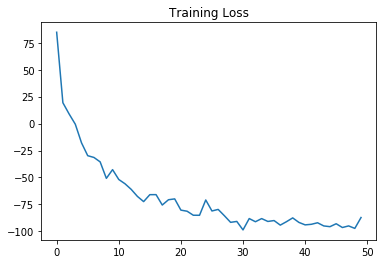

In [11]:
fig, ax = plt.subplots()
plt.plot(losses)
plt.title('Training Loss')
plt.legend()

In [12]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [13]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

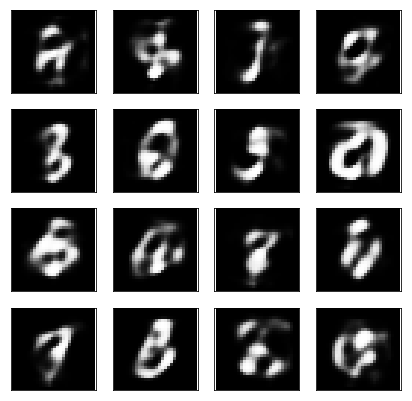

In [14]:
_ = view_samples(-1, samples)

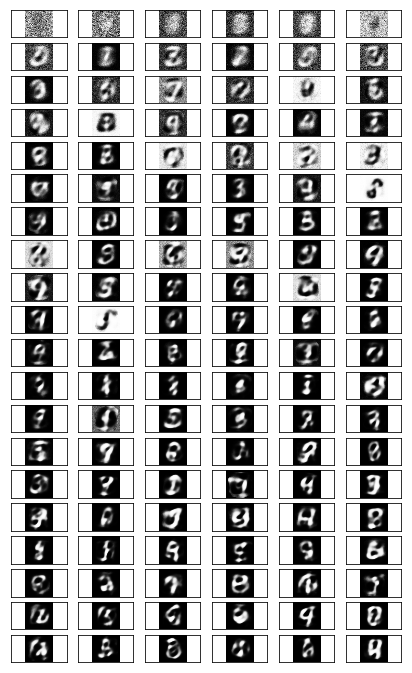

In [15]:
rows, cols = min(len(samples), 20), 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

In [16]:
# saver = tf.train.Saver()
# with tf.Session() as sess:
#     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
#     sample_z = np.random.uniform(-1, 1, size=(16, z_dim))
#     gen_samples = sess.run(
#                    generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
#                    feed_dict={input_z: sample_z})
# _ = view_samples(0, [gen_samples])